# AP(P)3RO PROJECT #

### Projet de deneigement intelligent de Montréal, Canada ###

#### M. Le Gras, A. Naullet, A. Calixte, P. Beaunieux ####

In [2]:
import multiprocessing as mp

import numpy as np
import osmnx as ox
from copy import copy

## Partie 1: Cartographie de la ville par le drone ##

In [591]:
place = "Montreal, Canada" # /!\ Replace with Montreal
G = ox.graph_from_place(place, network_type="walk")
#Gp = ox.project_graph(G)

In [250]:
print("There is", len(G.edges), "streets in this city")
print("There is", len(G.nodes), "nodes for this city")

There is 172844 streets in this city
There is 55571 nodes for this city


In [993]:
#G1 = ox.truncate.truncate_graph_dist(G,8753159525,max_dist=7500) #C
#G2 = ox.truncate.truncate_graph_dist(G,300155692,max_dist=5600) #L
#G3 = ox.truncate.truncate_graph_dist(G,1364932818,max_dist=3300) #F
#G4 = ox.truncate.truncate_graph_dist(G,32675009,max_dist=5500) #D
#G5 = ox.truncate.truncate_graph_dist(G,213784080,max_dist=3400) #G
G6 = ox.truncate.truncate_graph_dist(G,246285242,max_dist=4500) #I
#G7 = ox.truncate.truncate_graph_dist(G,26234647,max_dist=5000) #Ile
#G8 = ox.truncate.truncate_graph_dist(G,588566218,max_dist=6000) #B
#G9 = ox.truncate.truncate_graph_dist(G,8586746933,max_dist=8300) #A
#G10 = ox.truncate.truncate_graph_dist(G,583470197,max_dist=5200) #K
G11 = ox.truncate.truncate_graph_dist(G,31630568,max_dist=3200) # J
#G12 = ox.truncate.truncate_graph_dist(G,294966935,max_dist=10200) #M
#G13 = ox.truncate.truncate_graph_dist(G,29784717,max_dist=3400) #Donut
#G14 = ox.truncate.truncate_graph_dist(G,310090260,max_dist=2600) #mid

#G15 = ox.truncate.truncate_graph_dist(G,245354754,max_dist=18500)

In [994]:
#GRAPHS_LIST = [G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,G13,G14]
GRAPHS_LIST = [G6,G11]

### 1.1: Importation des plans de la ville ###

In [995]:
print("Whole City:")
#ox.plot_graph(G)

Whole City:


### Spliting

Le calcul du chemin Eulerien d'une ville aussi grande que Montréal serait vraiment très long, de plus on considère qu'un seul drone mettrai beaucoup trop de temps a parcourir la ville.

En effet, il faudrait que le drone parcours une distance de minimum ...

In [996]:
Total_Lenght = ox.stats.edge_length_total(G)
print(Total_Lenght/1000, "kilomètres")

12653.143369999761 kilomètres


On a decoupé notre ville en sous partie pour permettre aux drones de parcourir des distances totales d'envirron 1000 km.

Un drone professionel allant a une vitesse d'envirron 150 km/h, cette distance nous semble correcte

Voici Donc nos sous-graphes de la ville:

Sub part of city n°1


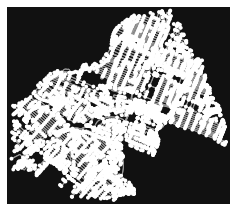

->  18444 streets in this part
->  5935 nodes for this part
->  1216.0724140000164 kilometers minimum
Sub part of city n°2


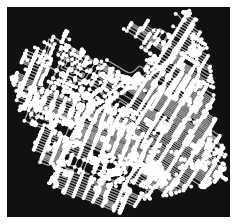

->  13448 streets in this part
->  4188 nodes for this part
->  973.9332360000005 kilometers minimum


In [997]:
for i, GG in enumerate(GRAPHS_LIST):
    print("Sub part of city n°%d" % (i + 1))
    ox.plot_graph(GG, figsize=(4,4))
    print("-> ", len(GG.edges), "streets in this part")
    print("-> ", len(GG.nodes), "nodes for this part")
    lenght = ox.stats.edge_length_total(GG)
    print("-> " , lenght/1000, "kilometers minimum")

In [998]:
### Construction d'une liste de noeud qui a notre format
def to_graph_city(GG):
    node_list = list(GG.edges(data=True))
    graph_city = []
    for node in node_list:
        n1 = node[0]
        n2 = node[1]
        dist = node[2]["length"]
        graph_city.append((n1,n2,dist))
    return graph_city
### On ne pgraph_cityeut pas utiliser l'id des noeuds pour utiliser nos algos.
### On doit construire une table de correspondance entre l'id des noeuds et des numéros croissants de noeuds

CORRESPONDENCE_TABLE = {}
CORRESPONDENCE_TABLE_PRIME = {}

def get_true_node(soft_id):
    if soft_id in CORRESPONDENCE_TABLE_PRIME:
        return CORRESPONDENCE_TABLE_PRIME[soft_id]
    return -1

def to_soft_id_graph(graph_city):
    global CORRESPONDENCE_TABLE_PRIME
    global CORRESPONDENCE_TABLE
    
    CORRESPONDENCE_TABLE_PRIME = {}
    CORRESPONDENCE_TABLE = {}
    
    graph_city_soft_id = []
    soft_id = 1
    
    len_g = len(graph_city)
    index = 1
    
    old_percentage = -1
    for (node1,node2,dist) in graph_city:
        #percentage = (index*100)//len_g
        #print("to soft_id: ",percentage, "%")
        #old_percentage = percentage
        if node1 not in  CORRESPONDENCE_TABLE:
            CORRESPONDENCE_TABLE[node1] = soft_id
            CORRESPONDENCE_TABLE_PRIME[soft_id] = node1
            soft_id += 1
            
        if node2 not in  CORRESPONDENCE_TABLE:
            CORRESPONDENCE_TABLE[node2] = soft_id
            CORRESPONDENCE_TABLE_PRIME[soft_id] = node2
            
            soft_id += 1
        s_id1 = CORRESPONDENCE_TABLE[node1]
        s_id2 = CORRESPONDENCE_TABLE[node2]
        graph_city_soft_id.append((s_id1,s_id2, dist))
    return graph_city_soft_id

def to_real_id_graph(graph_city_soft_id):
    graph_city = []
    soft_id = 1
    for (node1,node2,dist) in graph_city_soft_id:
        n_id1 = get_true_node(node1)
        n_id2 = get_true_node(node2)
    
        graph_city.append((n_id1,n_id2, dist))
    return graph_city

def to_real_id_path(path_soft_id):
    path = []
    soft_id = 1
    for (node1,node2) in path_soft_id:
        n_id1 = get_true_node(node1)
        n_id2 = get_true_node(node2)
    
        path.append(n_id1)
    return path

### 1.2 Calcul du parcours le plus efficace pour le drone ###

In [999]:
import sys
sys.path.append('./scripts')

import eulerian_transform as eulerian #cf nos scripts dans le dossier ./scripts/
import importlib
out = importlib.reload(eulerian) #Reload en cas de modifications des scripts

In [1000]:
### - - - Calcul des chemins Euleriens, temps estimé pour X sous-graphes = -60 min

PREDEF_COLORS = ["red", "yellow", "green", "cyan", "purple", "blue","pink", "brown", "white", "magenta", "orange", "#AAA003", "#A01DD3","#10ABB1", "#A01D11"] #TODO: ADD MORE

ROUTES = []
COLORS = []
for i, GG in enumerate(GRAPHS_LIST):
    print("\n[!] Dealing with sub part of city n°%d" % (i + 1))
    COLORS.append(PREDEF_COLORS[i])
    
    graph_city_2 = to_graph_city(GG)
    graph_city_soft_id_2 = to_soft_id_graph(graph_city_2)
    graph_city_2_prime = to_real_id_graph(graph_city_soft_id_2)
    print("[*] Conversion, re-conversion of graphs: ", ("Erreur","OK")[graph_city_2 == graph_city_2_prime])

    path2 = eulerian.transform_and_find_eulerian_path(graph_city_soft_id_2)
    path_real_id_2 = to_real_id_path(path2)
    ROUTES.append(path_real_id_2)


[!] Dealing with sub part of city n°1
[*] Conversion, re-conversion of graphs:  OK
[*] fixing the Graph
[+] Graph fixed
[*] Graph to dict
[*] Starting Fleury
[*] Compute Eulerian path: 100 % 
[+] Euleriand Path Found !

[!] Dealing with sub part of city n°2
[*] Conversion, re-conversion of graphs:  OK
[*] fixing the Graph
[+] Graph fixed
[*] Graph to dict
[*] Starting Fleury
[*] Compute Eulerian path: 100 % 
[+] Euleriand Path Found !


In [1001]:
# - - - Ajout d'une route
#CP_R = [C,L,F,D,G_z,I,Ile,B,A,K,J,M,Donut,mid] + [ROUTES[-1]]



# - - -  Test Modification/Amelioratin d'une Route
#       0 1 2 3 4   5 6   7 8 9 a b c      d
CP_R = [C,L,F,D,G_z,I,Ile,B,A,K,J,M,Donut,mid] + [] # copy
CP_R[0x5] = ROUTES[0] #numero approprié de modification
CP_R[0xa] = ROUTES[1]


#- - Si c'est concluant: decomenter les lignes necessaires
#FULL_ROUTES_BAK = CP_R
#(C,L,F,D,G_z,I,Ile,B,A,K,J,M,Donut, mid) = FULL_ROUTES_BAK

In [ ]:
# - - Affichage du graphe avec les différents parcours des drones
fig, ax = ox.plot_graph_routes(G, CP_R, route_colors=PREDEF_COLORS[0:14], route_linewidth=6, node_size=0)
#fig, ax = ox.plot_graph_routes(G, ROUTES, route_colors=COLORS, route_linewidth=6, node_size=0)

#- - On sauvegarde si les parcours nous conviennent
#FULL_ROUTES_BAK = ROUTES

In [951]:


#- - - Ecriture dans un script du tableau qui contient tous les parcours
#open("old_paths/BACKUP_DRONES_EULERIANS_PATHS.py", "w").write("FULL_ROUTES_BAK = " + str(FULL_ROUTES_BAK))

#- - - Si besoin:
#import old_paths.BACKUP_DRONES_EULERIANS_PATHS
# Then you can use FULL_ROUTES_BAK

### 1.3 Recuperation des données du drones (simulation d'eneigement) ###